# OPERA RTC Validation: Cross Correlation-based Relative Geolocation of a Stack

**Eric Lundell & Franz J Meyer; Alaska Satellite Facility, University of Alaska Fairbanks**
 
** This notebook is best ran on a machine that can handle 120 GB RAM and 32 CPUs **

This notebook analyzes the relative geolocation quality of OPERA RTC products using cross-correlation of images in a stack.

Once Dask is initialized and tiffs are selected, the rest of the notebook can be run automatically. Once a section is run, subsequent sections can be rerun independently. This can reduce the non-linear aspects of notebooks and also allow for more playing with code.   

The following procedures will be applied in this notebook:

1. Select directory containing OPERA RTC mosaics prepared using the `OPERA_RTC_download_reproject_mosaic_sample_bursts.ipynb` notebook
1. Tiffs in the selected polarization are copied to the same directory (`./vh/` or `./vv/`)
1. Superset tiffs to a common AOI, in-place
1. Due to spikes in data, flatten the tiffs by chopping off the top and bottom 1% of values. Save tiffs in `./{polarization}_flattened/`.
1. Because of NaNs and other areas of no-data, evenly tile the tiffs (default to 8x8). To speed things up, we use a Dask LocalCluster to multiprocess. Tiles are saved in `./{polarization}_flattened_tiles/`.
1. Apply the cross-correlation function to the individual tile nearest-chronological pairs. If more than 10% of a tile is NaNs, treat the whole tile as a NaN. Any remaining NaNs are converted to zero. Data is upscaled by a factor of ten. The cross correlation results include the shift in x and y and the RMSE. Results are converted from degrees to meters. The results are saved as json files for each tile pair in `./{polarization}_correlation/`.
1. Perform analysis on json results. Results are read into a Pandas DataFrame. A statistical description and graph of the results are shown in two ways: all tiles in a scene are averaged and all tiles are averaged in time. 

<hr>

# 0. OPERA RTC Relative Geolocation Requirement

<div class="alert alert-success">
<i>The Sentinel-1-based RTC product (RTC-S1) shall meet a relative geolocation accuracy better than or equal to 6 meters given the 30 meter RTC-S1 product resolution (i.e. 20% of the product resolution), excluding the effects of DEM errors, for at least 80% of all validation products considered.</i>
</div>

<hr>

# 1. Load Necessary Libraries

In [1]:
from pathlib import Path
import math
from datetime import datetime
import re
import json
import shutil
from tqdm.auto import tqdm

from ipyfilechooser import FileChooser
import rasterio
from rasterio.mask import mask
from shapely import geometry
from osgeo import gdal
gdal.UseExceptions()
import pandas as pd
import numpy as np
import dask.distributed
from skimage.registration import phase_cross_correlation
import matplotlib.pyplot as plt

import opensarlab_lib as asfn

%matplotlib inline

METERS_PER_PIXEL = 30

<hr>

# 2. Setup Dask Methods

Dask on a LocalCluster is used for multiprocessing to make some operations go faster. It is assumed that only one Dask client is used at one time.

In [2]:
def setup_dask(ram_per_worker_gb:int=20, num_workers:int=20, num_threads_per_worker:int=1) -> dask.distributed.Client:
    cluster = dask.distributed.LocalCluster(
        threads_per_worker=num_threads_per_worker,
        n_workers=num_workers,
        memory_limit=f"{ram_per_worker_gb}GB",
        processes=True
    )

    return dask.distributed.Client(cluster)

def teardown_dask(client: dask.distributed.Client) -> None:
    client.shutdown()

def do_dask(client: dask.distributed.Client, callback, args: list):
    try:
        futures = client.map(callback, args)
        dask.distributed.progress(futures)
    except Exception as e:
        print(f"Error in dask: {e}")
        teardown_dask(client)
        return
    
    _  = client.gather(futures)

<hr>

# 3. Select the directory holding your OPERA RTC sample data

Choose the parent directory of all child directories that contain the desired stack of OPERA sample RTCs, which were downloaded and mosaiced with `OPERA_RTC_download_reproject_mosaic_sample_bursts.ipynb`

```
stack_directory ──
                 │
                 │─ OPERA_RTC_mosaic_S1* ──
                 │                        │
                 │                        │─  OPERA_RTC_v0.4_vh_S1*.tif
                 │                        │─  OPERA_RTC_v0.4_vv_S1*.tif 
                 │                        │─  OPERA_RTC_v0.4_inc_angle_S1*.tif
                 │                        │─  OPERA_RTC_v0.4_local_inc_angle_S1*.tif
                 │                        │─  OPERA_RTC_v0.4_ls_mask_S1*.tif
                 │    
                 │─ OPERA_RTC_mosaic_S1* ──
                 │                        │
                 │                        │─  OPERA_RTC_v0.4_vh_S1*.tif
                 │                        │─  OPERA_RTC_v0.4_vv_S1*.tif 
                 │                        │─  OPERA_RTC_v0.4_inc_angle_S1*.tif
                 │                        │─  OPERA_RTC_v0.4_local_inc_angle_S1*.tif
                 │                        │─  OPERA_RTC_v0.4_ls_mask_S1*.tif
                 │          
                 .
                 .
                 .

```

In [4]:
print("Select directory holding stack of mosaiced OPERA RTCs produced using OPERA_RTC_download_reproject_mosaic_sample_bursts.ipynb")
fc = FileChooser(Path.cwd())
fc.show_only_dirs = True
display(fc)

Select directory holding stack of mosaiced OPERA RTCs produced using OPERA_RTC_download_reproject_mosaic_sample_bursts.ipynb


FileChooser(path='/home/jovyan/calval-RTC/cross_correlation_relative_geolocation_evaluation', filename='', tit…

In [5]:
stack_dir = Path(fc.selected)
vh_dir = stack_dir/"vh"
vv_dir = stack_dir/"vv"

try:
    vh_dir.mkdir()
except FileExistsError:
    pass
try:
    vv_dir.mkdir()
except FileExistsError:
    pass

vh_og = list(Path(fc.selected).glob("*/OPERA_RTC_mosaic_*/OPERA_RTC_v0.4_vh*_mosaic.tif"))
vv_og = list(Path(fc.selected).glob("*/OPERA_RTC_mosaic_*/OPERA_RTC_v0.4_vv*_mosaic.tif"))

In [6]:
for p in vh_og:
    if not (vh_dir/p.name).exists():
        shutil.copy(p, vh_dir/p.name)
for p in vv_og:
    if not (vv_dir/p.name).exists():
        shutil.copy(p, vv_dir/p.name)

In [7]:
vh = list(vh_dir.glob("OPERA_RTC_v0.4_vh*_mosaic.tif"))
vv = list(vv_dir.glob("OPERA_RTC_v0.4_vv*_mosaic.tif"))

<hr>

# 4. Superset OPERA RTC Images

Scene frames have a tendency to move over time. This means that the extant coverage for the whole scene is always different per frame. For the cross-correlation to properly work and for more accurate comparison, all the scenes need to be "normalized" by increasing/decreasing the size of the square extant. 

From extant metadata, get the full superset coordinates for all stack scenes.

In [9]:
print("Select a polarization on which to run cross-correlation") 
polar = asfn.select_parameter(['VH', 'VV'])
display(polar)

Select a polarization on which to run cross-correlation


RadioButtons(layout=Layout(min_width='800px'), options=('VH', 'VV'), value='VH')

In [10]:
polarization = polar.value.lower()

tiff_pths = vv if polarization == 'vv' else vh
tiff_pths

[PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200223T161213_20200223T161240_031382_039CB7_692D_mosaic.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200306T161213_20200306T161240_031557_03A2C3_55DC_mosaic.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200318T161213_20200318T161240_031732_03A8D7_1ABB_mosaic.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200423T161214_20200423T161241_032257_03BB4D_C693_mosaic.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200704T161218_20200704T161245_033307_03DBE4_E191_mosaic.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200505T161214_20200505T161241_032432_03C17C_6635_mosaic.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_

**Plot the first image in your stack to visualize some of the data.**

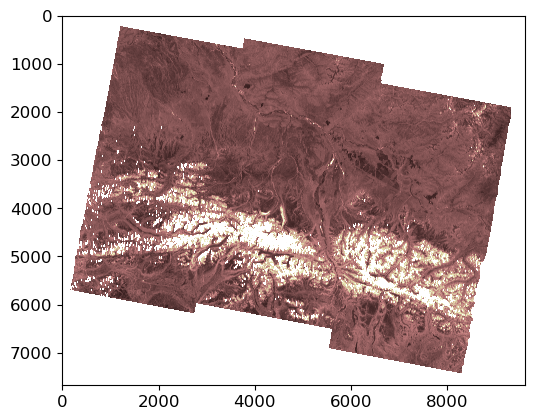

In [67]:
src = rasterio.open(tiff_pths[0], mode='r')
plt.imshow(src.read(1), cmap='pink', vmin=0.0, vmax=0.1)

In [12]:
# Open all the tiffs and get overall coords.
superset = {
    'left': math.inf,
    'bottom': math.inf,
    'right': -math.inf,
    'top': -math.inf
}

# The SRS is set to the first raster. It is assumed that the SRSs are the same (or close enough) for all.
output_srs = None

for i, original_path in enumerate(tiff_pths):

    raster = rasterio.open(original_path)    
    raster_bounds = raster.bounds
    print(raster_bounds)
    
    if i == 0:
        output_srs = raster.crs
    
    superset = {
        'left': min(superset['left'], raster_bounds.left),
        'bottom': min(superset['bottom'], raster_bounds.bottom), 
        'right': max(superset['right'], raster_bounds.right), 
        'top': max(superset['top'], raster_bounds.top)
    }

print(f"Superset box coords: {superset}")
print(f"Output SRS: {output_srs}")

BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(left=391740.0, bottom=6958140.0, right=680040.0, top=7188390.0)
BoundingBox(

In [13]:
output_bounds = (
            superset['left'], 
            superset['bottom'],
            superset['right'],
            superset['top'],
        )

print(f"Output bounds (superset) set to '{output_bounds}'")
print(f"Output SRS set to '{output_srs}'")

# Superset and save tiffs
for original_path in tqdm(tiff_pths):
   
    gdal.Warp(
        str(original_path),
        str(original_path), 
        outputBounds=output_bounds,
        outputBoundsSRS=output_srs,
        xRes=30.0, 
        yRes=30.0, 
        targetAlignedPixels=True,
    )
    

Output bounds (superset) set to '(391740.0, 6958140.0, 680040.0, 7188390.0)'
Output SRS set to 'EPSG:32606'


  0%|          | 0/14 [00:00<?, ?it/s]

<hr>

# 5. Flatten and Save RTCs

Often, the RTCs have extraneous high and low values that make matching difficult. So we need to get rid of these and save the intermediate results.

In [14]:
stack_dir

PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks')

In [17]:
flatten_dir = stack_dir/f"{polarization}_flattened"


# Remove any staged intermediate files to work in a clean area
!mkdir -p {flatten_dir}
for filepath in flatten_dir.glob("*.tif*"):
    filepath.unlink()

In [18]:
def flatten(df: pd.DataFrame) -> pd.DataFrame:
    """
    Truncated values become NaNs
    """
    df[df < np.nanpercentile(df, 1)] = np.nan
    df[df > np.nanpercentile(df, 99)] = np.nan
    return df

for p in tqdm(tiff_pths):
    print(f"Flattening {p}")
    
    # Convert raster to dataframe
    raster = rasterio.open(p)
    raster_metadata = raster.meta

    raster0 = raster.read(1)
    df = pd.DataFrame(raster0)
    
    # Flatten raster data
    df_flatten = flatten(df)
    
    flatten_path = flatten_dir/f"{p.stem}_flat.tif"
    
    with rasterio.open(flatten_path, 'w', **raster_metadata) as out:
        out.write(df_flatten, 1)

  0%|          | 0/14 [00:00<?, ?it/s]

Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200223T161213_20200223T161240_031382_039CB7_692D_mosaic.tif
Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200306T161213_20200306T161240_031557_03A2C3_55DC_mosaic.tif
Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200318T161213_20200318T161240_031732_03A8D7_1ABB_mosaic.tif
Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200423T161214_20200423T161241_032257_03BB4D_C693_mosaic.tif
Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200704T161218_20200704T161245_033307_03DBE4_E191_mosaic.tif
Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200505T161214_20200505T161241_032432_03C17C_6635_mosaic.tif
Flattening /home/jovyan/calval-RTC/S_of_Fairbanks/vh/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200411T161

<hr>

# 6. Tile and Save GeoTiffs

In [23]:
from typing import List

def split_into_cells_args(x_num: int, y_num: int, tiff_pths: List[Path], output_dir: Path) -> List:
    """
    return list of dict of args for `split_into_cells` dask function callback.
    """
    
    args = []
    for i, flatten_path in enumerate(tiff_pths):
        args.append({
            'input_number': i, 
            'input_file': flatten_path, 
            'output_dir': output_dir, 
            'x_num': x_num, 
            'y_num': y_num
        })
    
    return args 

# https://gis.stackexchange.com/a/306862
# Takes a Rasterio dataset and splits it into squares of dimensions squareDim * squareDim
def split_into_cells(args):
    """
    input_number: A sequential number representing the ordering of the scenes. This is to make later scene pairing easier.
    input_file: Full file path of scene to be tiled.
    output_dir: Full path of directory to place tiles.
    x_num: Number of tiles formed in the x direction per scene.
    y_num: Number of tiles formed in the y direction per scene.
    """
    
    input_number: int = args['input_number']
    input_file: str = args['input_file']
    output_dir: str = args['output_dir']
    x_num: int = args.get('x_num', 1)
    y_num: int = args.get('y_num', 1)
    
    print(f"Tileing {input_file}")

    
    raster = rasterio.open(input_file)
    
    x_dim = raster.shape[1] // x_num
    y_dim = raster.shape[0] // y_num

    x, y = 0, 0
    for y_iter in range(y_num):
        y = y_iter * y_dim
        for x_iter in range(x_num):
            x = x_iter * x_dim
            
            input_filestem = Path(input_file).stem
            
            output_file = f'{input_filestem}_{input_number}_{y_iter}_{x_iter}.tif'
            print(f"Creating tile {output_file}...")
            
            # Get tile geometry
            corner1 = raster.transform * (x, y)
            corner2 = raster.transform * (x + x_dim, y + y_dim)
            geom = geometry.box(corner1[0], corner1[1], corner2[0], corner2[1])
            
            # Get cell 
            crop, cropTransform = mask(raster, [geom], crop=True)
            raster.meta.update(
                {
                    "driver": "GTiff",
                    "height": crop.shape[1],
                    "width": crop.shape[2],
                    "transform": cropTransform,
                    "crs": raster.crs
                }
            )
                        
            output_filepath = f"{output_dir}/{output_file}"
            with rasterio.open(output_filepath, "w", **raster.meta) as out:
                out.write(crop)

In [20]:
# Remove any staged intermediate files to work in a clean area
tile_dir = stack_dir/f"{polarization}_flattened_tiles"
!mkdir -p {tile_dir}
for filepath in tile_dir.glob("*.tif*"):
    filepath.unlink()

In [24]:
X_NUM = 8
Y_NUM = 8

tiff_pths = list(flatten_dir.glob(f"*{polarization}*.tif"))

start_time = datetime.now()
print(f"\nStart time is {start_time}")

client = setup_dask(ram_per_worker_gb=20, num_workers=100, num_threads_per_worker=1)
do_dask(client, split_into_cells, split_into_cells_args(x_num=X_NUM, y_num=Y_NUM, tiff_pths=tiff_pths, output_dir=tile_dir))

teardown_dask(client)

end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")  


Start time is 2023-08-22 23:34:12.903428


/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39683 instead
  warnings.warn(
2023-08-23 00:09:15,371 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:36917', name: 18, status: running, memory: 0, processing: 1>
2023-08-23 00:09:15,398 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:36917'.
2023-08-23 00:09:43,024 - distributed.nanny - WARNING - Worker process still alive after 3.199997711181641 seconds, killing
2023-08-23 00:19:15,528 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:32805', name: 56, status: running, memory: 0, processing: 1>
2023-08-23 00:19:15,533 - distributed.scheduler - WARNING - Worker failed to heartbeat w

Tileing /home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat.tif
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_0_0.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_0_1.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_0_2.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_0_3.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_0_4.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_0_5.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_0

2023-08-23 00:45:19,555 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200704T161218_20200704T161245_033307_03DBE4_E191_mosaic_flat_0_7_7.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200306T161213_20200306T161240_031557_03A2C3_55DC_mosaic_flat_3_7_7.tif*...


/distributed/utils_comm.py", line 433, in retry
    return await coro()
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/core.py", line 1356, in send_recv_from_rpc
    return await send_recv(comm=comm, op=key, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/core.py", line 1115, in send_recv
    response = await comm.read(deserializers=deserializers)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 240, in read
    convert_stream_closed_error(self, e)
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 143, in convert_stream_closed_error
    raise CommClosedError(f"in {obj}: {exc}") from exc
distributed.comm.core.CommClosedError: in <TCP (

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200423T161214_20200423T161241_032257_03BB4D_C693_mosaic_flat_12_7_7.tif*...


2023-08-23 00:45:20,042 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_7_7.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200610T161217_20200610T161244_032957_03D145_A962_mosaic_flat_7_7_7.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200411T161213_20200411T161240_032082_03B52A_D3AC_mosaic_flat_2_7_7.tif*...


closed) ConnectionPool.heartbeat_worker local=tcp://127.0.0.1:39446 remote=tcp://127.0.0.1:43747>: Stream is closed
2023-08-23 00:45:20,311 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200223T161213_20200223T161240_031382_039CB7_692D_mosaic_flat_13_7_7.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200130T161213_20200130T161240_031032_039096_40CE_mosaic_flat_9_7_7.tif*...


2023-08-23 00:45:20,801 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200118T161214_20200118T161241_030857_038A73_DB38_mosaic_flat_6_7_7.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200505T161214_20200505T161241_032432_03C17C_6635_mosaic_flat_11_7_7.tif*...


2023-08-23 00:45:21,056 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200622T161217_20200622T161244_033132_03D696_EF40_mosaic_flat_1_7_7.tif*...


2023-08-23 00:45:21,296 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200318T161213_20200318T161240_031732_03A8D7_1ABB_mosaic_flat_10_7_7.tif*...


2023-08-23 00:45:21,638 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages

Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200211T161213_20200211T161240_031207_0396AE_B345_mosaic_flat_8_7_7.tif*...
Creating tile OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200330T161213_20200330T161240_031907_03AEFE_0E6B_mosaic_flat_5_7_7.tif*...


2023-08-23 00:45:22,400 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/comm/tcp.py", line 224, in read
    frames_nbytes = await stream.read_bytes(fmt_size)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/worker.py", line 1253, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/utils_comm.py", line 454, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages


End time is 2023-08-23 00:45:29.391295
Time elapsed is 1:11:16.487867



<hr>

# 7. Correlate Tiles and Save Results

In [48]:
def get_correlation_args(tiles_paths) -> list:
    """
    return [
        {
            'reference_index': '',
            'secondary_index': '',
            'tile_number_x': '',
            'tile_number_y': '',
            'ref_file_path': '',
            'sec_file_path': ''
        },
    ]
    """

    tiles = []
    
    # Get index and tile numbers from path
    for tiles_path in tiles_paths:

        m = re.match(r".*_([0-9]+)_([0-9]+)_([0-9]+).tif*", tiles_path.name)

        tiles.append({
            'index': m.group(1),
            'tile_number_x': m.group(2),
            'tile_number_y': m.group(3),
            'file_path': tiles_path
        })

    tiles_df = pd.DataFrame(tiles).sort_values(by=['tile_number_x', 'tile_number_y', 'index'])

    paris = []
    for i in range(len(tiles_df.index) - 1):

        #if i > 10:
        #    continue
        
        ref_row = tiles_df.iloc[i]
        sec_row = tiles_df.iloc[i+1]

        # If the next row in the sorted dataframe has different tile numbers, then we are at a new set
        if ref_row['tile_number_x'] != sec_row['tile_number_x'] or ref_row['tile_number_y'] != sec_row['tile_number_y']:
            continue

        paris.append({
            'reference_index': ref_row['index'],
            'secondary_index': sec_row['index'],
            'tile_number_x': ref_row['tile_number_x'],
            'tile_number_y': ref_row['tile_number_y'],
            'ref_file_path': ref_row['file_path'],
            'sec_file_path': sec_row['file_path']
        })

    return paris

def correlation_callback(args: dict) -> dict:
    """
    args = {
        'reference_index': '',
        'secondary_index': '',
        'tile_number_x': '',
        'tile_number_y': '',
        'ref_file_path': '',
        'sec_file_path': ''
    }
    """
    
    try:
        reference_index = args['reference_index']
        secondary_index = args['secondary_index']
        tile_number_x = args['tile_number_x']
        tile_number_y = args['tile_number_y']
        ref_file_path = args['ref_file_path']
        sec_file_path = args['sec_file_path']
        
        ###### Reference 
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Rendering {ref_file_path}...")
        rast = rasterio.open(ref_file_path)
        raster0 = rast.read(1)
        df_ref = pd.DataFrame(raster0)
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Time to complete ref: {datetime.now() - stime}")


        ###### Secondary
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Rendering {sec_file_path}...")
        rast = rasterio.open(sec_file_path)
        raster0 = rast.read(1)
        df_sec = pd.DataFrame(raster0)
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Time to complete sec: {datetime.now() - stime}")


        ###### If crop tile is more than 10% NANs, skip correlation and set return values to NaN 
        def get_percent_nans(df):
            number_of_elements = df.size
            number_of_nans = df.isnull().sum().sum()

            return number_of_nans / number_of_elements

        percent_nans_ref = get_percent_nans(df_ref)
        percent_nans_sec = get_percent_nans(df_sec)

        if percent_nans_ref > 0.10 or percent_nans_sec > 0.10:
            print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Too many NaNs. Skipping correlation....")

            result = {
                "reference_index": int(reference_index),
                "secondary_index": int(secondary_index),
                "tile_number_x": int(tile_number_x),
                "tile_number_y": int(tile_number_y),
                "ref_file": str(ref_file_path),
                "sec_file": str(sec_file_path),
                "shift_x": np.nan,
                "shift_y": np.nan, 
                "error": np.nan, 
                "phase": np.nan,
                "message": "Too many NaNs"
            }

        ####### Cross corr without masking
        stime = datetime.now()
        print(f"\nIndex {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Finding phase correlation with nans set to zero....")
        shift, error, phase = phase_cross_correlation(
            df_ref.replace(np.nan, 0), 
            df_sec.replace(np.nan, 0),
            normalization=None,
            upsample_factor=10
        )
        
        shift = shift * METERS_PER_PIXEL
        error = error * METERS_PER_PIXEL
        
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Shift vector (in meters) required to register moving_image with reference_image: {shift}")
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Translation invariant normalized RMS error between reference_image and moving_image: {error}")
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}: Global phase difference between the two images (should be zero if images are non-negative).: {phase}\n")

        if len(list(shift)) != 2:
            result = {
                "reference_index": int(reference_index),
                "secondary_index": int(secondary_index),
                "tile_number_x": int(tile_number_x),
                "tile_number_y": int(tile_number_y),
                "ref_file": str(ref_file_path),
                "sec_file": str(sec_file_path),
                "shift_x": np.float64(shift[0]),
                "shift_y": np.float64(shift[1]),
                "error": np.nan, 
                "phase": np.nan,
                "message": "Shift is not a two element array"
            }
        
        print(f"Index {reference_index} {secondary_index}, Tile {tile_number_x} {tile_number_y}:  Time to complete correlation: {datetime.now() - stime}")


        ####### Write metadata to correlation result files

        result = {
            "reference_index": int(reference_index),
            "secondary_index": int(secondary_index),
            "tile_number_x": int(tile_number_x),
            "tile_number_y": int(tile_number_y),
            "ref_file": str(ref_file_path),
            "sec_file": str(sec_file_path),
            "shift_x": np.float64(shift[0]),
            "shift_y": np.float64(shift[1]),
            "error": np.float64(error), 
            "phase": np.float64(phase),
            "message": "Correlation successful"
        }

    except Exception as e:
        print(f"An error occurred: {e}")
        result = {
            "reference_index": int(reference_index),
            "secondary_index": int(secondary_index),
            "tile_number_x": int(tile_number_x),
            "tile_number_y": int(tile_number_y),
            "ref_file": str(ref_file_path),
            "sec_file": str(sec_file_path),
            "shift_x": np.nan, 
            "shift_y": np.nan,
            "error": np.nan, 
            "phase": np.nan,
            "message": f"Error: {e}"
        }
        
    try:
        result_file = correlation_dir/f"index_{reference_index}_{secondary_index}-tile_{tile_number_x}_{tile_number_y}.json"
        with open(result_file, 'w') as f:
            json.dump(result, f)
    except Exception as e:
        print(f"An error occurred: {e}")

In [45]:
# Remove any staged intermediate files to work in a clean area
correlation_dir = stack_dir/f"{polarization}_correlation"
try:
    correlation_dir.mkdir()
except FileExistsError:
    pass

for filepath in correlation_dir.glob("*.json"):
    filepath.unlink()

In [49]:
flat_tif_pth = list(tile_dir.glob("*tif*"))
flat_tif_pth

[PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200529T161216_20200529T161243_032782_03CC1C_9C71_mosaic_flat_4_7_2.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200411T161213_20200411T161240_032082_03B52A_D3AC_mosaic_flat_2_3_0.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200318T161213_20200318T161240_031732_03A8D7_1ABB_mosaic_flat_10_2_7.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200423T161214_20200423T161241_032257_03BB4D_C693_mosaic_flat_12_3_6.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200505T161214_20200505T161241_032432_03C17C_6635_mosaic_flat_11_7_7.tif'),
 PosixPath('/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_

In [50]:
start_time = datetime.now()
print(f"\nStart time is {start_time}")

# ram_per_worker_gb:int=20, num_workers:int=20, num_threads_per_worker:int=1
client = setup_dask(ram_per_worker_gb=11, num_workers=10)
do_dask(client, correlation_callback, get_correlation_args(flat_tif_pth))

teardown_dask(client)

end_time = datetime.now()
print(f"\nEnd time is {end_time}")
print(f"Time elapsed is {end_time - start_time}\n")  


Start time is 2023-08-23 03:00:48.142261


/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44973 instead
  warnings.warn(



Index 2 3, Tile 0 0: Rendering /home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200411T161213_20200411T161240_032082_03B52A_D3AC_mosaic_flat_2_0_0.tif...
Index 2 3, Tile 0 0: Time to complete ref: 0:00:04.430778

Index 2 3, Tile 0 0: Rendering /home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200306T161213_20200306T161240_031557_03A2C3_55DC_mosaic_flat_3_0_0.tif...
Index 2 3, Tile 0 0: Time to complete sec: 0:00:01.419369

Index 2 3, Tile 0 0: Too many NaNs. Skipping correlation....

Index 2 3, Tile 0 0: Finding phase correlation with nans set to zero....
Index 2 3, Tile 0 0: Shift vector (in meters) required to register moving_image with reference_image: [3. 3.]
Index 2 3, Tile 0 0: Translation invariant normalized RMS error between reference_image and moving_image: 16.690814664156257
Index 2 3, Tile 0 0: Global phase difference between the two images (should be zero if images are non-negative)

/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_correlation_max.conj() /\
/home/jovyan/.local/envs/opera_calval_rtc/lib/python3.11/site-packages/skimage/registration/_phase_cross_correlation.py:111: RuntimeWarning: invalid value encountered in scalar divide
  error = 1.0 - cross_correlation_max * cross_co

Index 13 2, Tile 0 5: Time to complete sec: 0:00:00.411283

Index 13 2, Tile 0 5: Too many NaNs. Skipping correlation....

Index 13 2, Tile 0 5: Finding phase correlation with nans set to zero....
Index 13 2, Tile 0 5: Shift vector (in meters) required to register moving_image with reference_image: [0. 0.]
Index 13 2, Tile 0 5: Translation invariant normalized RMS error between reference_image and moving_image: 15.894435594467287
Index 13 2, Tile 0 5: Global phase difference between the two images (should be zero if images are non-negative).: 2.2175457026207823e-09

Index 13 2, Tile 0 5:  Time to complete correlation: 0:00:16.587171

Index 10 11, Tile 0 6: Rendering /home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPERA_RTC_v0.4_vh_S1A_IW_SLC__1SDV_20200318T161213_20200318T161240_031732_03A8D7_1ABB_mosaic_flat_10_0_6.tif...
Index 10 11, Tile 0 6: Time to complete ref: 0:00:00.181861

Index 10 11, Tile 0 6: Rendering /home/jovyan/calval-RTC/S_of_Fairbanks/vh_flattened_tiles/OPE

<hr>

# 8. Estimate Average Offsets Per Tile and For the Full Scene

Read the correlation result files from the previous section into a Pandas DataFrame.

Then perform various statistical analyses.

In [87]:
# Put results into 3D Pandas dataset
correlation_paths = correlation_dir.glob(f"*.json")

results = []

for corr_path in correlation_paths:
    with open(corr_path, 'r') as f:
        results.append(json.load(f))

results_df = pd.DataFrame(results)

In [88]:
display(results_df)

,reference_index,secondary_index,tile_number_x,tile_number_y,ref_file,sec_file,shift_x,shift_y,error,phase,message
0,1,10,6,3,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,24.628996,1.159753e-08,Correlation successful
1,2,3,7,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,15.137172,1.273829e-09,Correlation successful
2,3,4,7,7,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,-6.0,-6.0,22.465138,4.113217e-07,Correlation successful
3,11,12,6,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,19.433475,4.771914e-09,Correlation successful
4,5,6,3,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,17.455949,-2.232946e-09,Correlation successful
...,...,...,...,...,...,...,...,...,...,...,...
827,5,6,0,6,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,-21.0,-21.0,NaN,-0.000000e+00,Correlation successful
828,11,12,4,2,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,18.353392,-3.146161e-09,Correlation successful
829,0,1,7,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,-3.0,0.0,14.511924,-2.137183e-09,Correlation successful
830,10,11,1,5,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,-3.0,16.849658,-3.457099e-09,Correlation successful


Display the stats for the shift, error, and phase of the cross-correlation between two scenes in the stack.

The `reference_index` is the order number of the reference scene within the stack. The stack scenes are ordered from newest to oldest.
The `secondary_index` is the order number of the secondary scene within the stack.

The `mean` value is a simple mean of all tile values. Similarity for `std`, etc.

## A. Combine all tiles per scene pair correlation results

The cross-correlation results of all tiles in Scene 1 and Scene 2 are re-assembled together into one result and statistically analyzed. Repeat for all pairs. 

**First, remove invalid matches:**

In [89]:
dfff = results_df
dfff['error'] = dfff[dfff['error'] < 25.0]['error']
dfff['shift_x'] = dfff[np.abs(dfff['shift_x']) < 50.0]['shift_x']
dfff['shift_y'] = dfff[np.abs(dfff['shift_y']) < 50.0]['shift_y']
no_nans = dfff[~dfff.isnull().any(axis=1)]

In [75]:
# dfff = results_df
# dfff['error'] = dfff[dfff['error'] < 10.0]['error']
# dfff['shift_x'] = dfff[np.abs(dfff['shift_x']) < 50.0]['shift_x']
# dfff['shift_y'] = dfff[np.abs(dfff['shift_y']) < 50.0]['shift_y']
# no_nans = dfff[~dfff.isnull().any(axis=1)]

In [90]:
dfff

,reference_index,secondary_index,tile_number_x,tile_number_y,ref_file,sec_file,shift_x,shift_y,error,phase,message
0,1,10,6,3,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,24.628996,1.159753e-08,Correlation successful
1,2,3,7,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,15.137172,1.273829e-09,Correlation successful
2,3,4,7,7,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,-6.0,-6.0,22.465138,4.113217e-07,Correlation successful
3,11,12,6,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,19.433475,4.771914e-09,Correlation successful
4,5,6,3,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,17.455949,-2.232946e-09,Correlation successful
...,...,...,...,...,...,...,...,...,...,...,...
827,5,6,0,6,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,-21.0,-21.0,NaN,-0.000000e+00,Correlation successful
828,11,12,4,2,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,0.0,18.353392,-3.146161e-09,Correlation successful
829,0,1,7,4,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,-3.0,0.0,14.511924,-2.137183e-09,Correlation successful
830,10,11,1,5,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,/home/jovyan/calval-RTC/S_of_Fairbanks/vh_flat...,0.0,-3.0,16.849658,-3.457099e-09,Correlation successful


**Now calculate average scene-wide offsets along with their errors:**

,count,mean,std,min,25%,50%,75%,max
reference_index,,,,,,,,
0,58.0,-0.310345,1.216940,-6.0,0.0,0.0,0.0,3.0
1,45.0,-1.066667,2.038270,-9.0,-3.0,0.0,0.0,0.0
2,58.0,-0.051724,0.886990,-3.0,0.0,0.0,0.0,3.0
3,51.0,0.235294,1.975735,-6.0,0.0,0.0,0.0,9.0
4,51.0,-0.470588,1.736121,-9.0,0.0,0.0,0.0,3.0
5,58.0,0.155172,0.874627,0.0,0.0,0.0,0.0,6.0
6,52.0,0.519231,1.852295,-3.0,0.0,0.0,0.0,9.0
7,53.0,-0.396226,1.560814,-6.0,0.0,0.0,0.0,3.0
8,58.0,-0.051724,0.393919,-3.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
reference_index,,,,,,,,
0,58.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,45.0,1.333333,1.977142,-3.0,0.0,0.0,3.0,6.0
2,58.0,0.103448,0.552178,0.0,0.0,0.0,0.0,3.0
3,51.0,-1.705882,1.921397,-9.0,-3.0,-3.0,0.0,0.0
4,51.0,1.529412,1.836877,-3.0,0.0,0.0,3.0,6.0
5,58.0,-0.103448,0.552178,-3.0,0.0,0.0,0.0,0.0
6,52.0,-1.211538,1.993485,-6.0,-3.0,0.0,0.0,3.0
7,53.0,1.415094,1.915865,-3.0,0.0,0.0,3.0,6.0
8,58.0,-0.103448,0.552178,-3.0,0.0,0.0,0.0,0.0


,count,mean,std,min,25%,50%,75%,max
reference_index,,,,,,,,
0,58.0,16.020542,1.516345,14.082774,15.042571,15.371076,16.953852,19.766209
1,45.0,18.903678,2.562711,16.051722,16.989205,17.914475,20.613015,24.923179
2,58.0,16.254858,0.882402,14.808855,15.700660,16.076936,16.712162,19.183530
3,51.0,19.465385,3.133346,15.369838,16.820353,18.132683,22.864191,24.965708
4,51.0,19.039676,3.303208,15.275257,16.240021,17.508569,22.650736,24.951933
5,58.0,16.277437,1.033714,14.733407,15.480118,16.061023,16.728281,19.355603
6,52.0,18.952443,2.747055,15.331707,16.759926,17.993500,21.624039,24.126251
7,53.0,18.947235,2.937715,15.286196,16.370656,17.813866,21.720289,24.748047
8,58.0,15.419580,1.137265,13.895097,14.494529,15.195832,15.998290,18.833891


,tile_mean_x,tile_mean_y,error
reference_index,,,
0,-0.310345,0.000000,16.090911
1,-1.066667,1.333333,19.072771
2,-0.051724,0.103448,16.278379
3,0.235294,-1.705882,19.711077
4,-0.470588,1.529412,19.318553
5,0.155172,-0.103448,16.309663
6,0.519231,-1.211538,19.146704
7,-0.396226,1.415094,19.169378
8,-0.051724,-0.103448,15.460741


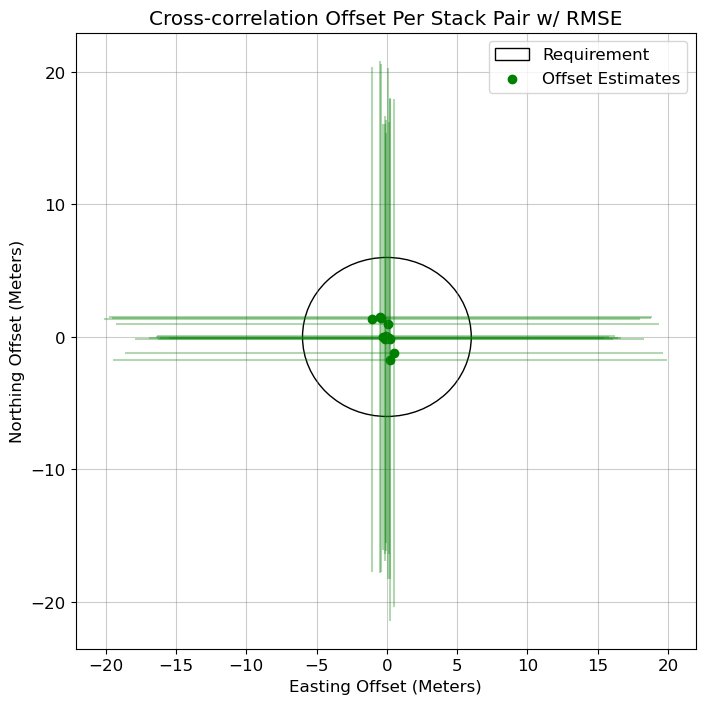

In [91]:
paired_dfff = no_nans.groupby(by=['reference_index'])

## Uncomment to display statistical descriptions of DataFrames
display(paired_dfff['shift_x'].describe())
display(paired_dfff['shift_y'].describe())
display(paired_dfff['error'].describe())

display(paired_dfff)

# Take the Root Mean Square Error of the individual tile RMSE to get the overall RMSE.
def rms(series):
    if np.isnan(series).all():
        return np.nan  
    return np.sqrt(np.nanmean(np.square(series)))
    #return np.nanmean(np.abs(series))

pdfff = pd.DataFrame()
pdfff['tile_mean_x'] = paired_dfff['shift_x'].agg(['mean'])
pdfff['tile_mean_y'] = paired_dfff['shift_y'].agg(['mean'])
pdfff['error'] = paired_dfff['error'].agg(rms)
display(pdfff)

fig, ax = plt.subplots(figsize=(8,8))
Circle1= plt.Circle(( 0.0 , 0.0 ), 6.0, fill=False, label='Requirement')
ax.add_patch(Circle1)
plt.grid(color='grey', alpha=0.4)
plt.errorbar(pdfff['tile_mean_x'], pdfff['tile_mean_y'], yerr=pdfff['error'], xerr=pdfff['error'], ecolor='green', alpha=0.3, ls='none')
plt.scatter(pdfff['tile_mean_x'], pdfff['tile_mean_y'], color='green', label='Offset Estimates')
ax.legend()
plt.xlabel("Easting Offset (Meters)")
plt.ylabel("Northing Offset (Meters)")
plt.title("Cross-correlation Offset Per Stack Pair w/ RMSE")

plt.savefig(correlation_dir/'CrossCorrelationOffsets-FullFrame.png', dpi=300, transparent='true')

## B. Combine all tile correlation results temporally

The cross-correlation result of each individual tile for Scene 1 and Scene 2 are combined together temporally with the corresponding tile in later pairs. This creates a time series by tile. Repeat for all tiles. This is statistically analyzed. 

tile_mean_x  tile_mean_y      error
tile_number_x tile_number_y                                     
0             0                 0.230769    -0.230769  16.862721
              1                 0.000000     0.461538  16.192742
              2                -0.230769     0.230769  16.676155
              3                -0.230769     0.461538  15.454394
              4                -0.692308     0.230769  16.741976
              5                -0.461538    -0.230769  17.052451
1             0                 0.230769     0.230769  16.914358
              1                -0.230769     0.692308  15.327458
              2                 0.000000     0.461538  15.571468
              3                 0.000000     0.461538  15.766690
              4                 0.000000     0.230769  15.717282
              5                -0.230769     0.000000  16.171081
              6                -0.461538     0.230769  16.893306
              7                -0.461538     0.230769  19.641902
2             0                -0.461538     0.230769  16.443668
              1                -0.692308     0.461538  15.317880
              2                 0.000000     0.461538  15.636750
              3                 0.000000     0.461538  16.358693
              4                 0.000000     0.461538  16.652770
              5                 0.000000     0.230769  15.966716
              6                 0.000000     0.230769  16.639651
              7                 0.000000     0.000000  18.781807
3             0                 0.000000     0.000000  17.851020
              1                 0.000000     0.000000  18.102256
              2                 0.000000     0.000000  18.572003
              3                 0.000000     0.230769  16.921479
              4                 0.000000     0.461538  17.583838
              5                 0.000000     0.461538  16.711865
              6                 0.000000     0.230769  15.600404
              7                 0.000000     0.000000  18.096410
4             0                 0.000000     0.000000  17.447911
              1                 0.000000     0.000000  19.167544
              2                 0.000000     0.000000  20.616528
              3                 0.000000     0.000000  21.193452
              4                 0.000000     0.000000  18.819261
              5                 0.000000     0.000000  19.504675
              6                 0.000000     0.230769  17.148736
              7                 0.000000     0.230769  16.064749
5             0                 0.000000     0.000000  18.895745
              1                 0.000000     0.000000  19.569606
              2                 0.300000     0.000000  19.485172
              3                 0.000000     0.000000  17.916297
              4                 0.000000     0.000000  19.507715
              5                 0.000000     0.000000  19.911229
              6                 0.000000     0.000000  17.210395
              7                 0.000000     0.000000  19.446260
6             0                -0.545455     0.000000  19.469793
              1                 0.000000     0.230769  17.100934
              2                 0.000000     0.000000  19.564134
              3                 0.000000     0.000000  19.296424
              4                 0.000000    -0.230769  19.832818
              5                 0.000000     0.000000  20.380547
              6                 0.000000     0.000000  18.434046
              7                 0.230769    -0.230769  19.968015
7             4                -0.461538    -0.230769  16.320980
              5                 0.000000     0.461538  15.865200
              6                 0.230769     0.000000  17.496329
              7                -1.384615    -0.923077  20.546579

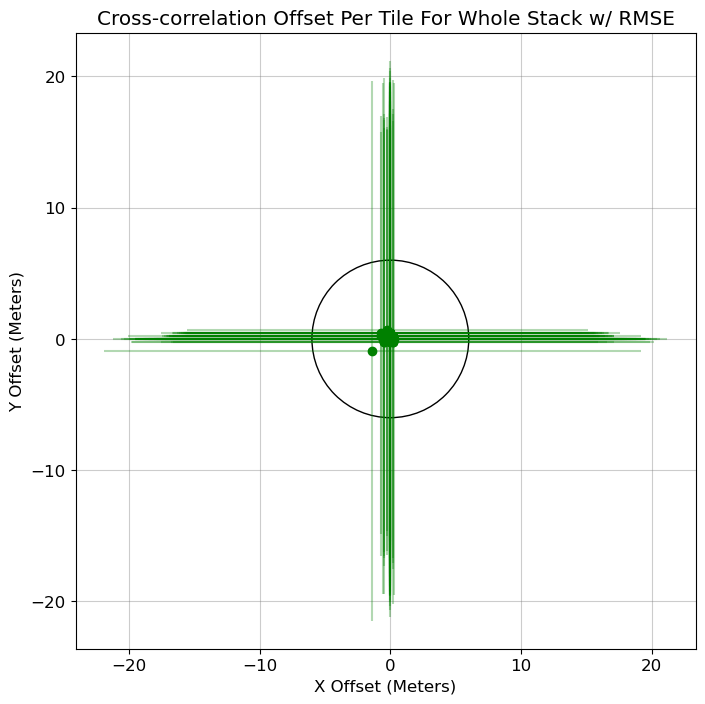

In [92]:
# temporal_df = results_df.groupby(by=['tile_number_x', 'tile_number_y'])
temporal_df = no_nans.groupby(by=['tile_number_x', 'tile_number_y'])


## Uncomment to display statistical descriptions of DataFrames
#display(temporal_df['shift_x'].describe())
#display(temporal_df['shift_y'].describe())
#display(temporal_df['error'].describe())

def rms(series):
    if np.isnan(series).all():
        return np.nan  
    return np.sqrt(np.nanmean(np.square(series)))
    #return np.nanmean(np.abs(series))

tdf = pd.DataFrame()
tdf['tile_mean_x'] = temporal_df['shift_x'].agg(['mean'])
tdf['tile_mean_y'] = temporal_df['shift_y'].agg(['mean'])
tdf['error'] = temporal_df['error'].agg(rms)
display(tdf)

fig, ax = plt.subplots(figsize=(8,8))
Circle1= plt.Circle(( 0.0 , 0.0 ), 6.0, fill=False)
ax.add_patch(Circle1)
plt.grid(color='grey', alpha=0.4)
plt.errorbar(tdf['tile_mean_x'], tdf['tile_mean_y'], yerr=tdf['error'], xerr=tdf['error'], ecolor='green', alpha=0.3, ls='none')
plt.scatter(tdf['tile_mean_x'], tdf['tile_mean_y'], color='green')
plt.xlabel("X Offset (Meters)")
plt.ylabel("Y Offset (Meters)")
plt.title("Cross-correlation Offset Per Tile For Whole Stack w/ RMSE")
plt.savefig('CrossCorrelationOffsets-Tiles.png', dpi=300, transparent='true')